# Visualize Sentinel-2 Bands
Sample a random valid pixel from the clipped mosaic and visualize band values.

- Default raster: `data/processed/mosaic_s2_oct_2016_clipped.tif` (resolved from project root).
- Bands follow the download pipeline (B2, B3, B4, B5, B6, B7, B8, B8A).


In [4]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.windows import Window

default_rel = Path('data/processed/mosaic_s2_oct_2016_clipped.tif')
project_root = Path.cwd()
if project_root.name == 'notebooks':
    project_root = project_root.parent
candidate = project_root / default_rel
if candidate.exists():
    raster_path = candidate
else:
    matches = list(project_root.rglob(default_rel.name))
    if not matches:
        raise FileNotFoundError(f'Could not locate {default_rel} from project root {project_root}')
    raster_path = matches[0]

print(f'Using raster: {raster_path}')
print(f'Current working dir: {Path.cwd()}')


Using raster: f:\brahmanbariavegetation\data\processed\mosaic_s2_oct_2016_clipped.tif
Current working dir: f:\brahmanbariavegetation\notebooks


In [5]:
def sample_random_valid_pixel(src, attempts=1000):
    for _ in range(attempts):
        row = np.random.randint(0, src.height)
        col = np.random.randint(0, src.width)
        mask = src.read_masks(1, window=Window(col, row, 1, 1))
        if mask[0, 0] == 0:
            continue  # nodata pixel
        values = src.read(src.indexes, window=Window(col, row, 1, 1))[:, 0, 0]
        x, y = src.transform * (col + 0.5, row + 0.5)
        return (row, col), (x, y), values
    raise ValueError('No valid pixel found after multiple attempts; check your raster/mask.')

with rasterio.Env(GDAL_TIFF_INTERNAL_MASK=False, GDAL_PAM_ENABLED=False):
    with rasterio.open(raster_path) as src:
        (row, col), (x, y), values = sample_random_valid_pixel(src)
        band_labels = list(src.descriptions) if src.descriptions and any(src.descriptions) else ['B2','B3','B4','B5','B6','B7','B8','B8A'][: len(src.indexes)]

print(f'Random valid pixel at row={row}, col={col}, coords=({x:.5f}, {y:.5f})')
print('Band values:')
for label, val in zip(band_labels, values):
    print(f'  {label}: {val}')


Random valid pixel at row=5049, col=3980, coords=(91.07897, 23.81438)
Band values:
  B2: 1167.2189207218908
  B3: 1049.8638316176957
  B4: 778.3993294723513
  B5: 1038.1326396200052
  B6: 2092.6314045516865
  B7: 2557.1847820361922
  B8: 2384.4695697488514
  B8A: 2780.202124900042


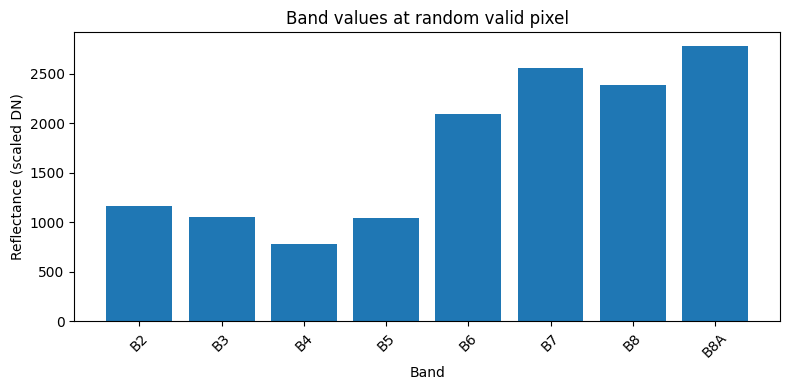

In [6]:
plt.figure(figsize=(8, 4))
plt.bar(range(len(values)), values, tick_label=band_labels)
plt.title('Band values at random valid pixel')
plt.ylabel('Reflectance (scaled DN)')
plt.xlabel('Band')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
